# Imports and Constants

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
DB_NAME = 'Northwind_small.sqlite'
RANDOM_STATE = 42

# Connect to Database

In [3]:
conn = sqlite3.connect(DB_NAME)

In [4]:
cur = conn.cursor()

## Get Table Names

In [5]:
q = """
    SELECT name FROM sqlite_master
    WHERE type='table'
    ORDER BY name;
    """

In [6]:
cur.execute(q)
cur.fetchall()

[('Category',),
 ('Customer',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Employee',),
 ('EmployeeTerritory',),
 ('Order',),
 ('OrderDetail',),
 ('Product',),
 ('Region',),
 ('Shipper',),
 ('Supplier',),
 ('Territory',)]

**The table names do not match the provided schema.  The names in the schema are all plural, vs. singular in the actual database.**

# Review Contents of Order Details Table

The data on discounts is in this table.

In [7]:
q = """
    SELECT * FROM OrderDetail LIMIT 10;
    """

In [8]:
cur.execute(q)
cur.fetchall()

[('10248/11', 10248, 11, 14, 12, 0.0),
 ('10248/42', 10248, 42, 9.8, 10, 0.0),
 ('10248/72', 10248, 72, 34.8, 5, 0.0),
 ('10249/14', 10249, 14, 18.6, 9, 0.0),
 ('10249/51', 10249, 51, 42.4, 40, 0.0),
 ('10250/41', 10250, 41, 7.7, 10, 0.0),
 ('10250/51', 10250, 51, 42.4, 35, 0.15),
 ('10250/65', 10250, 65, 16.8, 15, 0.15),
 ('10251/22', 10251, 22, 16.8, 6, 0.05),
 ('10251/57', 10251, 57, 15.6, 15, 0.05)]

Load table into dataframe and review discount details

In [9]:
q = """
    SELECT * FROM OrderDetail;
    """

In [10]:
order_detail_df = pd.DataFrame(cur.execute(q).fetchall(), 
                               columns = [description[0] for description in cur.description])

In [11]:
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


## What types of discounts are there and how many of each?

In [12]:
discount_val_counts = order_detail_df.Discount.value_counts()

In [13]:
discount_val_counts

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [14]:
discounts_given_count = len(order_detail_df) - discount_val_counts[0]
discounts_given_count

838

838 discounts were given vs. 1317 than had no discount.

Look at the value counts ordered by the discount value 

In [15]:
discount_val_counts_sorted = discount_val_counts.sort_index()

In [16]:
discount_val_counts_sorted

0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Discount, dtype: int64

## How many unique orders are in this table?

In [17]:
order_detail_df.OrderId.nunique()

830

# What is the total number of items in each order?

In [18]:
od_gb_order_id_df = order_detail_df[['OrderId', 'Quantity']].groupby('OrderId').sum()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115357978>]],
      dtype=object)

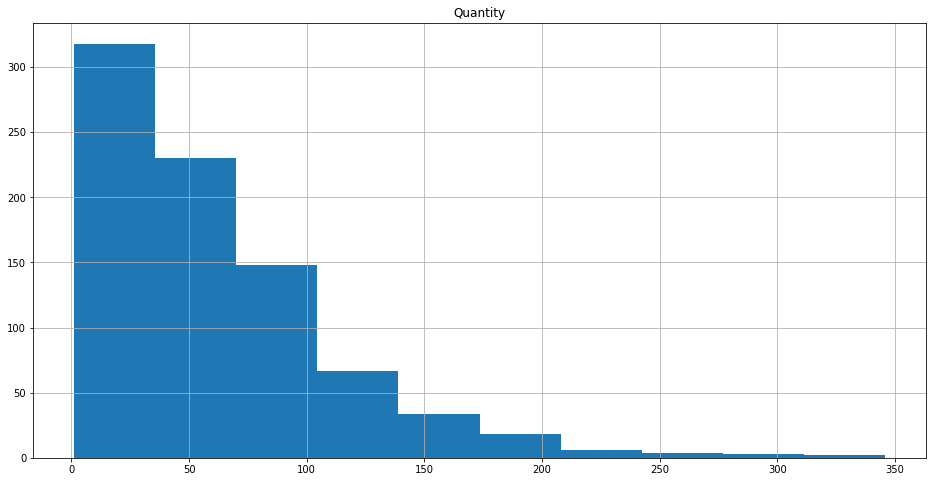

In [19]:
od_gb_order_id_df.hist(figsize=(16, 8))

In [20]:
od_gb_order_id_df['Quantity'].describe()

count    830.000000
mean      61.827711
std       50.748158
min        1.000000
25%       26.000000
50%       50.000000
75%       81.000000
max      346.000000
Name: Quantity, dtype: float64

The distribution of the quantity of items in an order is highly skewed to the right, with orders tending to be on the lower total quantity.

How many orders were for only 1 item?

In [21]:
len(od_gb_order_id_df[od_gb_order_id_df.Quantity == 1.0])

2

# What products have received discounts?

In [22]:
products_with_discount = order_detail_df[order_detail_df['Discount'] > 0.0]

In [23]:
products_with_discount.ProductId.nunique()

77

In [24]:
order_detail_df.ProductId.nunique()

77

All the products received a discount at least once.

# Explore Regions

In [25]:
region_q = """
           SELECT * FROM Region
           """

In [47]:
region_df = pd.DataFrame(cur.execute(region_q).fetchall(), 
                               columns = [description[0] for description in cur.description])

In [48]:
region_df

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


## There are four regions...How many customers are in each region?

In [87]:
cust_in_region_q = """
                   SELECT Region.RegionDescription,
                          COUNT(DISTINCT `Order`.CustomerID) AS NumCust
                          
                   FROM Region
                   JOIN Territory
                   ON Region.ID = Territory.RegionID
                   JOIN EmployeeTerritory
                   ON Territory.ID = EmployeeTerritory.TerritoryID
                   JOIN Employee
                   ON EmployeeTerritory.EmployeeID = Employee.ID
                   JOIN `Order`
                   ON Employee.ID = `Order`.EmployeeID
                   GROUP BY Region.ID
                   """

In [88]:
region_df = pd.DataFrame(cur.execute(cust_in_region_q).fetchall(), 
                               columns = [description[0] for description in cur.description])

In [89]:
region_df

,RegionDescription,NumCust
0,Eastern,89
1,Western,69
2,Northern,65
3,Southern,63


Although the Eastern region has 20 to 26 more active customers than the other 3 regions, they are pretty similar in size.

### Look at the overall data on order totals

In [121]:
order_totals_q = """
                 SELECT `Order`.ID AS OrderID,
                        `Order`.CustomerID,
                        `Order`.EmployeeID,
                        SUM (CASE 
                                WHEN OrderDetail.Discount = 0.0
                                THEN OrderDetail.UnitPrice * OrderDetail.Quantity
                                ELSE OrderDetail.UnitPrice * OrderDetail.Quantity * OrderDetail.Discount
                             END) AS OrderTotal
                 FROM `Order`
                 JOIN OrderDetail
                 ON `Order`.ID = OrderDetail.OrderID
                 GROUP BY `Order`.ID
                 """

In [108]:
order_totals_df = pd.DataFrame(cur.execute(order_totals_q).fetchall(), 
                               columns = [description[0] for description in cur.description])

In [109]:
order_totals_df.head()

,OrderID,CustomerId,EmployeeId,OrderTotal
0,10248,VINET,5,440.00
1,10249,TOMSP,6,1863.40
2,10250,HANAR,4,337.40
3,10251,VICTE,3,352.74
4,10252,SUPRD,4,1220.10


What are the descriptive statistics for OrderTotal?

In [110]:
order_totals_df.OrderTotal.describe()

count      830.000000
mean      1011.282121
std       1531.659830
min          4.200000
25%        182.480000
50%        517.300000
75%       1206.950000
max      15810.000000
Name: OrderTotal, dtype: float64

That max ordertotal of $15,810 seems like an outlier.  What does the data look like on a scatterplot?

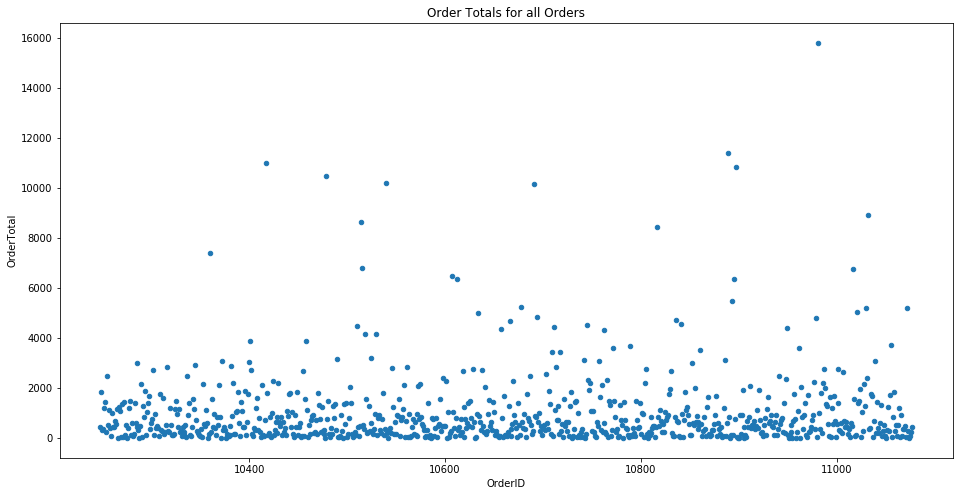

In [114]:
order_totals_df.plot.scatter(x='OrderID', 
                             y='OrderTotal', 
                             figsize=(16,8), 
                             title='Order Totals for all Orders')

The $15,810 does look like an outlier, but it could be a customer that bought one big order vs. a lot of smaller orders.  It needs further investigation before being left out of any further analysis.

What does the distribution look like?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11646bf28>]],
      dtype=object)

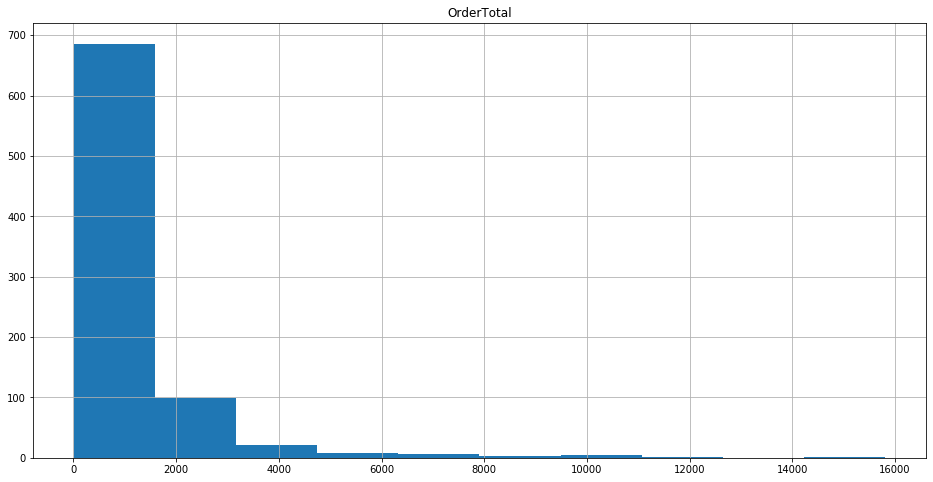

In [119]:
order_totals_df.hist(column='OrderTotal', figsize=(16,8))

It's highly skewed to the right. The lack of negative order totals seems to indicate that there were no returns.

Let's only look at orders under 1206 (the 3rd quartile)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115ffc208>]],
      dtype=object)

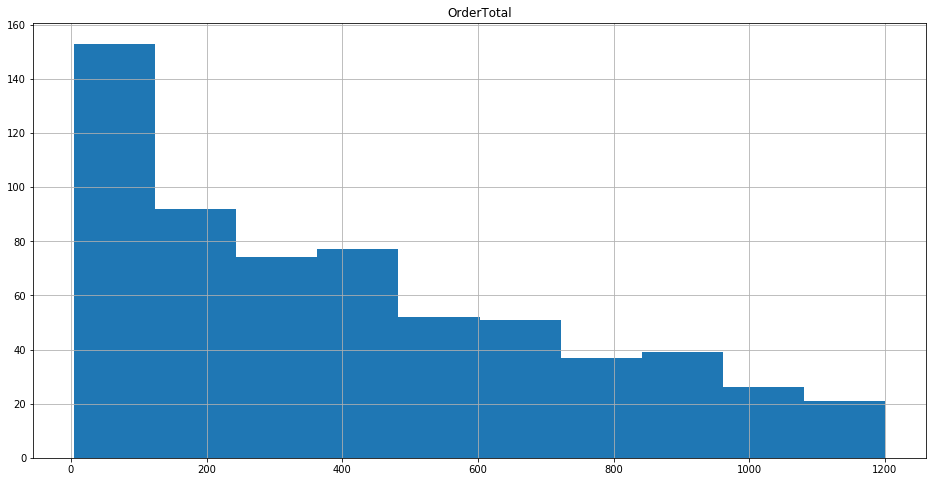

In [120]:
order_totals_df[order_totals_df.OrderTotal <= 1206.95].hist(column='OrderTotal', figsize=(16,8))

The distribution is still skewed to the right, but more detail of the bulk of the orders (which are small) can be seen which is described well by the median OrderTotal value.

### Look at the OrderTotal data per region